[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Data Head:
                   PL=F         PA=F
Date                               
2023-07-03  909.299988  1218.400024
2023-07-05  918.099976  1249.300049
2023-07-06  904.500000  1230.800049
2023-07-07  910.099976  1236.500000
2023-07-10  929.200012  1228.099976
Data Tail:
                    PL=F        PA=F
Date                               
2024-06-24   999.099976  976.099976
2024-06-25   983.700012  933.700012
2024-06-26  1020.700012  922.700012
2024-06-27   991.700012  927.599976
2024-06-28  1001.900024  977.900024
Cointegration p-value: 0.03650789881247105
Signals Head:
             longs  shorts  exits
Date                            
2023-07-03   True   False  False
2023-07-05   True   False  False
2023-07-06   True   False  False
2023-07-07   True   False  False
2023-07-10   True   False  False
Spread and Z-Score Head:
 Date
2023-07-03   -309.100037
2023-07-05   -331.200073
2023-07-06   -326.300049
2023-07-07   -326.400024
2023-07-10   -298.899963
dtype: float64 Date
2023-07

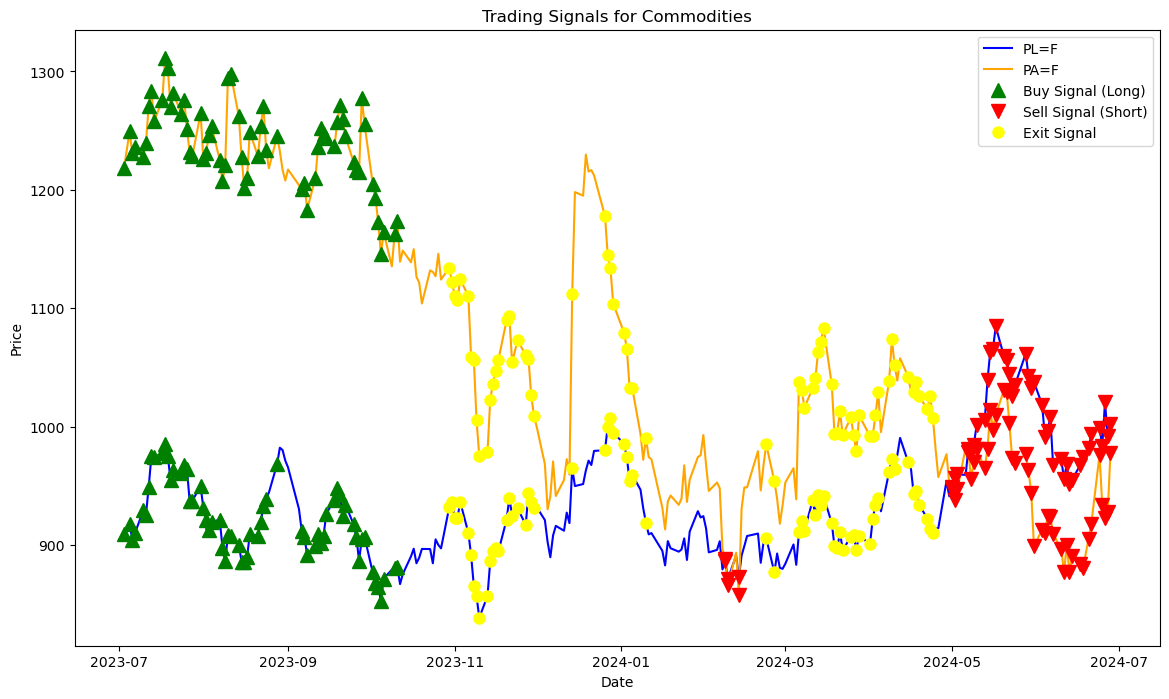

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Function to import commodities data from Yahoo Finance
def import_commod_data(tickers, start_date, end_date):
    data = pd.DataFrame()
    for t in tickers:
        data[t] = yf.download(t, start=start_date, end=end_date)['Adj Close']  # Download adjusted closing prices
    data = data.replace([np.inf, -np.inf], np.nan).dropna()  # Remove infinite and NaN values
    return data

# Define commodities and date range
start_date = '2023-07-01'
end_date = '2024-07-01'
commodities = ['PL=F', 'PA=F']

# Download data
data = import_commod_data(commodities, start_date, end_date)
print("Data Head:\n", data.head())
print("Data Tail:\n", data.tail())

# Function to compute spread and Z-score
def spread_and_zscore(series1, series2):
    spread = series1 - series2  # Calculate the spread between two series
    z_score = (spread - spread.mean()) / spread.std()  # Calculate the Z-score of the spread
    return spread, z_score

# Function to check for cointegration between two series
def check_cointegration(series1, series2):
    result = sm.tsa.stattools.coint(series1, series2)  # Perform the cointegration test
    p_val = result[1]  # Extract the p-value from the cointegration test results
    return p_val

# Check for cointegration between the selected commodities
p_value = check_cointegration(data[commodities[0]], data[commodities[1]])
print(f'Cointegration p-value: {p_value}')

# Function to generate trading signals based on Z-score
def generate_signals(data, commodities):
    series1 = data[commodities[0]]
    series2 = data[commodities[1]]
    
    spread, z_score = spread_and_zscore(series1, series2)  # Compute spread and Z-score
    
    # Generate trading signals based on Z-score thresholds
    longs = z_score < -1  # Long signal when Z-score is less than -1
    shorts = z_score > 1  # Short signal when Z-score is greater than 1
    exits = abs(z_score) < 0.5  # Exit signal when Z-score is between -0.5 and 0.5
    
    signals = pd.DataFrame(index=data.index)
    signals['longs'] = longs
    signals['shorts'] = shorts
    signals['exits'] = exits
    
    return signals, spread, z_score

signals, spread, z_score = generate_signals(data, commodities)
print("Signals Head:\n", signals.head())
print("Spread and Z-Score Head:\n", spread.head(), z_score.head())

# Function to backtest the strategy
def backtest(signals, data, commodities):
    positions = pd.DataFrame(index=signals.index)
    positions[commodities[0]] = 0  # Initialize positions for the first commodity
    positions[commodities[1]] = 0  # Initialize positions for the second commodity

    for i in range(len(signals)):
        if signals['longs'].iloc[i]:  # Long signal
            total_value = 1000  # Total value to be invested in each position
            positions.iloc[i] = [total_value / data[commodities[0]].iloc[i], -total_value / data[commodities[1]].iloc[i]]
        elif signals['shorts'].iloc[i]:  # Short signal
            total_value = 1000  # Total value to be invested in each position
            positions.iloc[i] = [-total_value / data[commodities[0]].iloc[i], total_value / data[commodities[1]].iloc[i]]
        elif signals['exits'].iloc[i]:  # Exit signal
            positions.iloc[i] = [0, 0]  # Set positions to zero on exit
    
    # Calculate daily returns of the assets
    daily_rets = data.pct_change().dropna()
    # Calculate portfolio returns based on positions and daily returns
    returns = (positions.shift(1) * daily_rets).sum(axis=1)
    # Calculate cumulative returns over the period
    cumulative_rets = (returns + 1).cumprod() - 1

    return positions, returns, cumulative_rets



# Function to calculate performance metrics
def calculate_performance_metrics(cumulative_rets, returns):
    total_return = cumulative_rets.iloc[-1]  # Total return over the period
    # Calculate the annualized return
    annualized_return = ((1 + total_return) ** (252 / len(cumulative_rets)) - 1) * 100
    # Calculate the Sharpe ratio
    sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252)
    
    return total_return, annualized_return, sharpe_ratio

total_return, annualized_return, sharpe_ratio = calculate_performance_metrics(cumulative_rets, returns)
print(f"Total Return: {total_return * 100:.2f}%")
print(f"Annualized Return: {annualized_return:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Plot Prices and Trading Signals
# Extract trading signals and price data
long_signals = signals['longs']
short_signals = signals['shorts']
exit_signals = signals['exits']

plt.figure(figsize=(14, 8))
plt.plot(data.index, data[commodities[0]], label=commodities[0], color='blue')
plt.plot(data.index, data[commodities[1]], label=commodities[1], color='orange')
plt.plot(data.index[long_signals], data[commodities[0]][long_signals], '^', markersize=10, color='green', label='Buy Signal (Long)')
plt.plot(data.index[long_signals], data[commodities[1]][long_signals], '^', markersize=10, color='green')
plt.plot(data.index[short_signals], data[commodities[0]][short_signals], 'v', markersize=10, color='red', label='Sell Signal (Short)')
plt.plot(data.index[short_signals], data[commodities[1]][short_signals], 'v', markersize=10, color='red')
plt.plot(data.index[exit_signals], data[commodities[0]][exit_signals], 'o', markersize=8, color='yellow', label='Exit Signal')
plt.plot(data.index[exit_signals], data[commodities[1]][exit_signals], 'o', markersize=8, color='yellow')
plt.title('Trading Signals for Commodities')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
